# 基于 Skip-Gram 实现一个简单的word2vec

![Skip_Gram](Skip_Gram.png)

## 1 基于Skip-Gram训练词向量：当前词（中心词）与其周围的词共同出现的概率更大，即向量更相似

### 1.1 概率公式

$$ P(W_{i-1}|W_i) = \frac{\exp{(u_{w_{i-1}}^T * v_{w_i}})}{\sum_{w=i}^V{\exp{(u_{w_i-1}^T * v_{w_i})}}} $$

### 1.2 Negative-Sampling => 损失函数

$$ Loss = -(\log{(u_i v_i)} + \sum^N{\log{(-u_i v_n)}}) $$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook
import numpy as np

## 1.3 代码部分

### 1.3.1 SkipGramModel，用于计算损失

In [2]:
class SkipGramModel(nn.Module):
    def __init__(self, device, vocab_size, embedd_dim, neg_num=0, word_count=[]):
        super(SkipGramModel, self).__init__()
        self.device = device
        self.neg_num = neg_num
        self.embeddings = nn.Embedding(vocab_size, embedd_dim)
#         initrange = 0.5 / embedd_dim
#         self.embeddings.weight.data.uniform_(-initrange, initrange)
        if self.neg_num > 0:
            self.table = create_sample_table(word_count)
        
    def forward(self, centers, context):
        '''
            params: centers: batch_size, 1
            params: context: batch_size, 1
        '''
        batch_size = len(centers)
        u_embeddings = self.embeddings(centers).view(batch_size, 1, -1)  # batch_size, 1, embedd_dim
        v_embeddings = self.embeddings(context).view(batch_size, 1, -1)  # batch_size. 1, embedd_dim
        #print('size check for u and v embedding: ', u_embeddings.size(), v_embeddings.size())
        score = torch.bmm(u_embeddings, v_embeddings.transpose(1, 2)).squeeze()  # batch_size,
        loss = F.logsigmoid(score).squeeze() # batch_size,
        #print('size check for loss: ', loss.size())
        if self.neg_num > 0:
            neg_contexts = torch.LongTensor(np.random.choice(self.table, size=(batch_size, self.neg_num))).to(self.device)
            
            neg_v_embeddings = self.embeddings(neg_contexts)  # batch_size, neg_num, embedd_dim
            neg_score = torch.bmm(u_embeddings, neg_v_embeddings.transpose(1, 2).neg()).squeeze()  # batch_size, neg_num
            neg_score = F.logsigmoid(neg_score).squeeze()  # batch_size,
            neg_score = torch.sum(neg_score, dim=1) # batch_size, 
            #print('size check for neg_score: ', neg_score.size())
            assert loss.size() == neg_score.size()
            loss += neg_score
        return -1 * loss.sum()
    
    def get_embeddings(self):
        return self.embeddings.weight.data

### 1.3.2 根据词频设定负采样词

In [3]:
TABLE_SIZE = 1e8
def create_sample_table(words_count):
    table = []
    freq = np.power(np.array(words_count), 0.75)
    print('freq: ', freq)
    sum_freq = sum(freq)
    ratio = freq / sum_freq
    count = np.round(ratio * TABLE_SIZE)
    print('count: ', count)
    for word_id, c in enumerate(count): # 处理后的词频
        table += [word_id] * int(c)
    return np.array(table)

### 1.3.3 获取PTB数据集

In [4]:
from torchnlp.datasets import penn_treebank_dataset

def get_ptb_data():
    train_sentences, temp = [], []
    original_train = penn_treebank_dataset(train=True)
    for x in original_train:
        if x != '</s>': temp.append(x)
        else: 
            train_sentences.append(temp)
            temp = []
    sentence_length = sum([1 for x in original_train if x == '</s>'])
    return train_sentences, sentence_length

### 1.3.4 得到PTB数据集的词表、词频统计、词汇

In [5]:
from collections import Counter

min_word_freq = 3
def get_words_map_and_words_count(train_sentences):
    words_freq = Counter()
    for sen in train_sentences:  # 遍历每个句子，更新词频表
        words_freq.update(sen)
    words = [w for w in words_freq.keys() if words_freq[w] > min_word_freq]  # 根据最小词频，筛选出符合条件的词
    words_map = {v: k for k, v in enumerate(words)}  # 词汇表
    words_count = [words_freq[k] for k, v in words_map.items()]  # 词频统计
    return words_map, words_count, words

### 1.3.5 一句话一个列表

In [6]:
def get_clean_train(train_sentences, words):
    res, temp_sen = [], []
    for i, sen in enumerate(train_sentences):
        print('the {}th sentence: {}'.format(i, sen))
        for ch in sen:
            if ch in words: temp_sen.append(ch)
            else: temp_sen.append('<unk>')
        res.append(temp_sen)
        temp_sen = []
    return res

### 1.3.6 得到所有<中心词，上下文词>对

In [32]:
from collections import defaultdict

def get_center_context_pairs(train_sentences, words_map, window_size):
    pairs, pair = [], defaultdict(list)
    max_dis = window_size // 2
    # 每个句子
    for i, sen in enumerate(train_sentences):
        if i%1000 == 0: print('the {}th sentence'.format(i))
        if len(sen) < 5: continue
        # 每个中心词
        for j in range(0, len(sen)):
            center_id = words_map.get(sen[j], words_map['<unk>'])
            # 根据中心词和窗口大小， 选择每个上下文词
            start = j-max_dis if j>max_dis else 0
            end = j+max_dis+1 if j<len(sen)-max_dis else len(sen)
            for idx in range(start, j): # 左半部分
                pair[center_id].append(words_map.get(sen[idx], words_map['<unk>']))    
            for idx in range(j+1, end): # 右半部分
                pair[center_id].append(words_map.get(sen[idx], words_map['<unk>'])) 
            pairs.append(pair)
            pair = defaultdict(list)
    return pairs

### 一些参数

In [8]:
Config = {
    'learning_rate':0.001,
    'embedding_dim':200,
    'window_size':5,
    'batch_size':64,
    'epoch':6,
    'weight_decay':0.5,
    'neg_num':12
}

In [9]:
train_sentences, sentence_len = get_ptb_data()

In [10]:
words_map, words_count, words = get_words_map_and_words_count(train_sentences)

In [11]:
train = get_clean_train(train_sentences, words)

the 0th sentence: ['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter']
the 1th sentence: ['pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N']
the 2th sentence: ['mr.', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n.v.', 'the', 'dutch', 'publishing', 'group']
the 3th sentence: ['rudolph', '<unk>', 'N', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate']
the 4th sentence: ['a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', 'to

In [33]:
train_pairs = get_center_context_pairs(train, words_map, Config['window_size'])

the 0th sentence
the 1000th sentence
the 2000th sentence
the 3000th sentence
the 4000th sentence
the 5000th sentence
the 6000th sentence
the 7000th sentence
the 8000th sentence
the 9000th sentence
the 10000th sentence
the 11000th sentence
the 12000th sentence
the 13000th sentence
the 14000th sentence
the 15000th sentence
the 16000th sentence
the 17000th sentence
the 18000th sentence
the 19000th sentence
the 20000th sentence
the 21000th sentence
the 22000th sentence
the 23000th sentence
the 24000th sentence
the 25000th sentence
the 26000th sentence
the 27000th sentence
the 28000th sentence
the 29000th sentence
the 30000th sentence
the 31000th sentence
the 32000th sentence
the 33000th sentence
the 34000th sentence
the 35000th sentence
the 36000th sentence
the 37000th sentence
the 38000th sentence
the 39000th sentence
the 40000th sentence
the 41000th sentence
the 42000th sentence


In [34]:
len(train_pairs)

884157

In [35]:
train_pairs[10000:11000]

[defaultdict(list, {2189: [2187, 2188, 715, 245]}),
 defaultdict(list, {715: [2188, 2189, 245, 815]}),
 defaultdict(list, {245: [2189, 715, 815, 218]}),
 defaultdict(list, {815: [715, 245, 218, 68]}),
 defaultdict(list, {218: [245, 815, 68, 7]}),
 defaultdict(list, {68: [815, 218, 7, 2190]}),
 defaultdict(list, {7: [218, 68, 2190, 94]}),
 defaultdict(list, {2190: [68, 7, 94, 2185]}),
 defaultdict(list, {94: [7, 2190, 2185, 2191]}),
 defaultdict(list, {2185: [2190, 94, 2191, 54]}),
 defaultdict(list, {2191: [94, 2185, 54, 2192]}),
 defaultdict(list, {54: [2185, 2191, 2192, 55]}),
 defaultdict(list, {2192: [2191, 54, 55, 188]}),
 defaultdict(list, {55: [54, 2192, 188, 83]}),
 defaultdict(list, {188: [2192, 55, 83, 113]}),
 defaultdict(list, {83: [55, 188, 113, 17]}),
 defaultdict(list, {113: [188, 83, 17, 7]}),
 defaultdict(list, {17: [83, 113, 7, 220]}),
 defaultdict(list, {7: [113, 17, 220, 2193]}),
 defaultdict(list, {220: [17, 7, 2193, 1754]}),
 defaultdict(list, {2193: [7, 220, 1754

In [36]:
reverse_words_map = {v: k for k, v in words_map.items()}

In [37]:
reverse_words_map[2], reverse_words_map[0], reverse_words_map[1], reverse_words_map[3], reverse_words_map[4] 

('N', 'pierre', '<unk>', 'years', 'old')

### 拿到所有的对

In [38]:
def get_all_pairs(train_pairs):
    all_data = []
    center_idx, context_idx = [], []
    for pair in train_pairs:
        for k, v in pair.items():
            center_idx = k
            for x in v:
                context_idx.append(x)
        for con in context_idx:
            all_data.append((center_idx, con))
        center_idx, context_idx = [], []
    return all_data

In [39]:
all_data = get_all_pairs(train_pairs)

In [40]:
all_data = list(set(all_data))

In [41]:
all_data[500:1000]

[(1092, 2899),
 (7097, 799),
 (4787, 2855),
 (4887, 2856),
 (23, 6985),
 (2783, 9243),
 (300, 2463),
 (925, 17),
 (4859, 4858),
 (503, 5),
 (6388, 23),
 (5434, 6840),
 (1944, 39),
 (844, 199),
 (76, 8588),
 (23, 9335),
 (2783, 4433),
 (3146, 399),
 (1185, 133),
 (88, 2147),
 (138, 8251),
 (188, 6766),
 (434, 2227),
 (9800, 4454),
 (412, 1799),
 (3143, 302),
 (5412, 7014),
 (2373, 358),
 (4592, 478),
 (94, 9789),
 (560, 3420),
 (1447, 146),
 (6910, 150),
 (331, 250),
 (2848, 1104),
 (278, 455),
 (312, 2050),
 (2220, 1547),
 (1070, 6574),
 (156, 9344),
 (2304, 2302),
 (9630, 30),
 (1029, 62),
 (2239, 4070),
 (1006, 433),
 (8433, 134),
 (362, 5284),
 (1626, 154),
 (2201, 2258),
 (178, 250),
 (2745, 1293),
 (1266, 349),
 (3174, 290),
 (1838, 1839),
 (538, 2398),
 (535, 282),
 (94, 2386),
 (390, 815),
 (1113, 1930),
 (1266, 1728),
 (781, 2658),
 (156, 2129),
 (2201, 1924),
 (3501, 419),
 (94, 4041),
 (719, 478),
 (1551, 127),
 (1113, 103),
 (903, 7620),
 (1459, 15),
 (781, 7),
 (1018, 2481)

In [42]:
len(all_data)

911964

### 提取 一个batch的对

In [43]:
def get_batch_pairs(batch_size, all_data):
    batch_center, batch_context = [], []
    batch_index = np.random.choice(len(all_data), batch_size)
    for idx in batch_index:
        t_center, t_context = all_data[idx]
        batch_center.append(t_center)
        batch_context.append(t_context)
    return torch.LongTensor(batch_center), torch.LongTensor(batch_context)

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

### 模型model

In [45]:
assert len(words) == len(words_map) == len(words_count)

In [46]:
model = SkipGramModel(device=device, vocab_size=len(words), embedd_dim=Config['embedding_dim'], neg_num=Config['neg_num'], word_count=words_count)

freq:  [   3.83365863 3090.68054223 2419.48003981 ...    5.19615242    3.83365863
    3.83365863]
count:  [   2037. 1642496. 1285796. ...    2761.    2037.    2037.]


### 优化器

In [47]:
optimizor = optim.Adam(model.parameters(), lr=Config['learning_rate'], weight_decay=Config['weight_decay'])

### 主要训练代码

In [48]:
iter_time = len(train_pairs) // Config['batch_size']
loss_items = []
batch_size = Config['batch_size']
for e in tqdm_notebook(range(Config['epoch'])):
    for i in range(iter_time):
        center, context = get_batch_pairs(batch_size, all_data)
        # print('size check: ', center.size(), context.size())
        
        loss = model(center, context)
        if i % 500 == 0: print(reverse_words_map[int(center[0])], reverse_words_map[int(context[0])])
#         if i % 1000 == 0: print('parameters: {}'.format(list(model.parameters())[0][0]))
            
        loss.backward()
        optimizor.step()
        optimizor.zero_grad()
        loss_items.append(loss.item()) 
        if i % 1000 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.10f}'.format(e, i * batch_size, iter_time * batch_size,
                                                                             100. * i / iter_time, loss.item()))

energy evaluate
Train Epoch: 0 [0/884096 (0%)]	Loss: 4212.3408203125
create campaigns
worth &
Train Epoch: 0 [64000/884096 (7%)]	Loss: 1539.5854492188
saturday three
los mines
Train Epoch: 0 [128000/884096 (14%)]	Loss: 667.1096191406
enserch limited
bid prepared
Train Epoch: 0 [192000/884096 (22%)]	Loss: 610.1158447266
rid him
with swap
Train Epoch: 0 [256000/884096 (29%)]	Loss: 575.2323608398
i glad
off point
Train Epoch: 0 [320000/884096 (36%)]	Loss: 578.7019653320
anne of
merger would
Train Epoch: 0 [384000/884096 (43%)]	Loss: 577.0137939453
be mistake
execution delayed
Train Epoch: 0 [448000/884096 (51%)]	Loss: 576.6878051758
technological for
remain until
Train Epoch: 0 [512000/884096 (58%)]	Loss: 576.6981201172
has fox
across mr.
Train Epoch: 0 [576000/884096 (65%)]	Loss: 576.6984863281
under assistance
forecast eased
Train Epoch: 0 [640000/884096 (72%)]	Loss: 576.6984863281
and submitted
wall prepared
Train Epoch: 0 [704000/884096 (80%)]	Loss: 576.6984863281
component financial


In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

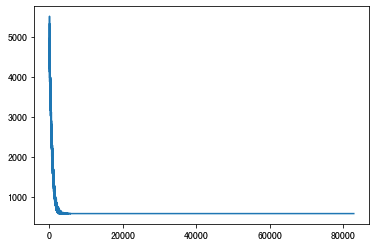

In [50]:
plt.plot(loss_items)

In [51]:
embeddings = model.get_embeddings()

In [52]:
embeddings.size()

torch.Size([9930, 200])

In [53]:
embeddings[10].size()

torch.Size([200])

In [54]:
def get_word_embeddings(words, embeddings):
    idx = words_map.get(words, 1)
    if idx == 1:
        print('Unknown word: {}', words)
        return None
    else:
        return embeddings[idx]

In [55]:
def get_cos_distance(word1, word2, embeddings):
    '''
        :params word1 embedd_size
        :params word2 embedd_size
    '''
    w1_e, w2_e = get_word_embeddings(word1, embeddings), get_word_embeddings(word2, embeddings)
    print('word1 size:{}, word2 size:{}'.format(w1_e.size(), w2_e.size()))
    return torch.cosine_similarity(w1_e.unsqueeze(0), w2_e.unsqueeze(0))

In [56]:
 get_cos_distance('phone', 'computer', embeddings)

word1 size:torch.Size([200]), word2 size:torch.Size([200])


tensor([0.0735])

In [57]:
get_cos_distance('man', 'woman', embeddings)

word1 size:torch.Size([200]), word2 size:torch.Size([200])


tensor([0.0076])

In [89]:
get_cos_distance('boy', 'girl', embeddings)

word1 size:torch.Size([200]), word2 size:torch.Size([200])


tensor([-0.2962])

## 2 基于K-means的聚类

In [58]:
from sklearn.cluster import KMeans

In [59]:
np_embeddings = np.array(embeddings)

In [60]:
kmeans = KMeans(n_clusters=1000, random_state=0).fit(np_embeddings)

In [61]:
kmeans.labels_

array([231, 586,  74, ..., 231, 231, 357], dtype=int32)

In [62]:
count_for_labels = Counter()

In [63]:
count_for_labels.update(kmeans.labels_)

In [64]:
count_for_labels

Counter({231: 4485,
         586: 1,
         74: 1,
         410: 1,
         298: 6,
         724: 1,
         531: 364,
         638: 1,
         876: 65,
         789: 1,
         160: 1,
         992: 16,
         643: 5,
         537: 1,
         600: 1,
         215: 1,
         83: 1,
         36: 417,
         105: 6,
         760: 51,
         825: 72,
         150: 1,
         673: 1,
         418: 1,
         8: 108,
         50: 7,
         313: 1,
         659: 14,
         385: 1,
         781: 42,
         119: 10,
         71: 27,
         766: 10,
         140: 1,
         392: 1,
         795: 1,
         499: 1,
         320: 1,
         212: 1,
         49: 19,
         34: 9,
         114: 30,
         883: 1,
         261: 1,
         268: 15,
         186: 1,
         95: 7,
         366: 1,
         619: 24,
         253: 105,
         630: 1,
         612: 1,
         952: 252,
         906: 1,
         399: 19,
         438: 1,
         391: 102,
         984

In [65]:
import pandas as pd

In [66]:
df = pd.DataFrame(np_embeddings)

In [67]:
df.head(5)

0             1         2             3         4             5    \
0  0.000004 -2.982561e-07 -0.000001  2.653424e-07 -0.000003  7.023897e-07   
1 -0.001482  4.954604e-04 -0.000406 -3.416510e-04 -0.000291  2.090730e-04   
2  0.001734 -3.978489e-04  0.000139 -1.333444e-05  0.000071 -1.183178e-04   
3 -0.000029  1.029705e-04  0.000827  4.411842e-06  0.000073 -4.040566e-05   
4 -0.000502  8.128437e-05 -0.000107 -8.834857e-05  0.000088 -1.434355e-05   

            6             7             8         9    ...           190  \
0  9.282405e-08  5.113527e-07 -1.953766e-07 -0.000003  ... -9.789737e-07   
1  1.374303e-04 -6.184565e-04  1.217753e-04  0.000969  ... -2.962470e-04   
2  5.926469e-04  1.212770e-04 -3.792769e-04  0.000023  ... -6.519337e-05   
3 -4.536741e-04 -6.354177e-05  1.658408e-04 -0.000737  ...  5.212849e-04   
4  2.797746e-04 -3.129813e-05  1.363121e-04  0.000064  ... -4.185167e-04   

            191       192           193           194       195           196  \
0  1.138950e-07 -0.000003  6.809238e-07 -2.411164e-07 -0.000002 -8.646209e-08   
1  8.976184e-05 -0.000565 -8.145344e-04 -3.569294e-04 -0.000180 -1.000061e-04   
2 -7.053563e-04  0.000406  1.624366e-03  9.261767e-04  0.000365  1.247626e-03   
3 -1.302899e-05  0.000220 -5.305686e-04 -1.574972e-06  0.000347 -2.414019e-04   
4  9.336902e-05  0.000164 -3.487643e-04  2.322558e-04 -0.000088  2.768876e-04   

        197           198       199  
0  0.000002 -9.348673e-07  0.000005  
1 -0.000307  3.862586e-04 -0.000508  
2 -0.000332  1.543081e-04  0.000010  
3 -0.000261 -4.777150e-05 -0.000276  
4  0.000023  5.125766e-05 -0.000307  

[5 rows x 200 columns]

In [68]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

In [69]:
tsne = TSNE(n_components=2, init='pca', random_state=1)

In [70]:
embedd = tsne.fit_transform(np_embeddings)

### 将embedding和word对应

In [71]:
rev_words_map = {v: k for k, v in words_map.items()}

In [72]:
number_of_words_to_show = 300

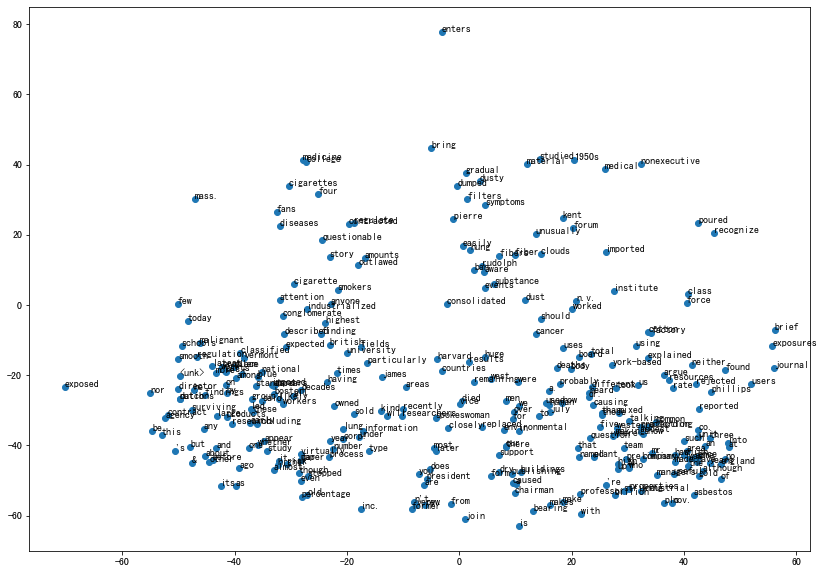

In [73]:
#可视化
plt.figure(figsize=(14,10))
plt.scatter(embedd[:number_of_words_to_show,0], embedd[:number_of_words_to_show,1])
 
for i in range(number_of_words_to_show):
    x = embedd[i][0]
    y = embedd[i][1]
    plt.text(x, y, rev_words_map[i])
plt.show()

## 3 同义词挖掘，与Glove Embedding进行对比

In [75]:
with open('./glove.6B.200d.txt', 'r') as f:
    temp_glove = f.readlines()

In [76]:
glove_words, glove_embeddings = [], []

In [77]:
for line in temp_glove:
    glove_words.append(line.split(" ")[0])
    glove_embeddings.append(line.split(" ")[1:])

In [78]:
for e in glove_embeddings:
    for i, data in enumerate(e):
        if i==len(e)-1:
            e[i] = e[i].split("\n")[0]

In [79]:
glove_embeddings[0]

['-0.071549',
 '0.093459',
 '0.023738',
 '-0.090339',
 '0.056123',
 '0.32547',
 '-0.39796',
 '-0.092139',
 '0.061181',
 '-0.1895',
 '0.13061',
 '0.14349',
 '0.011479',
 '0.38158',
 '0.5403',
 '-0.14088',
 '0.24315',
 '0.23036',
 '-0.55339',
 '0.048154',
 '0.45662',
 '3.2338',
 '0.020199',
 '0.049019',
 '-0.014132',
 '0.076017',
 '-0.11527',
 '0.2006',
 '-0.077657',
 '0.24328',
 '0.16368',
 '-0.34118',
 '-0.06607',
 '0.10152',
 '0.038232',
 '-0.17668',
 '-0.88153',
 '-0.33895',
 '-0.035481',
 '-0.55095',
 '-0.016899',
 '-0.43982',
 '0.039004',
 '0.40447',
 '-0.2588',
 '0.64594',
 '0.26641',
 '0.28009',
 '-0.024625',
 '0.63302',
 '-0.317',
 '0.10271',
 '0.30886',
 '0.097792',
 '-0.38227',
 '0.086552',
 '0.047075',
 '0.23511',
 '-0.32127',
 '-0.28538',
 '0.1667',
 '-0.0049707',
 '-0.62714',
 '-0.24904',
 '0.29713',
 '0.14379',
 '-0.12325',
 '-0.058178',
 '-0.001029',
 '-0.082126',
 '0.36935',
 '-0.00058442',
 '0.34286',
 '0.28426',
 '-0.068599',
 '0.65747',
 '-0.029087',
 '0.16184',
 '0.0

In [80]:
glove_embeddings = np.array(glove_embeddings)

In [81]:
glove_embeddings = glove_embeddings.astype(float)

In [82]:
glove_embeddings[0]

array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
        3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
        1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
       -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
        4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
        7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
        1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
       -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
       -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
        6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
       -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
        8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
        1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
        1.4379e-01, -1.2325e-01, -5.8178e-02, -1.0290e-03, -8.21

In [83]:
glove_words_embeddings = dict(zip(glove_words, glove_embeddings))

In [84]:
def get_glove_embedding_cos(word1, word2):
    w1_e, w2_e = torch.FloatTensor(glove_words_embeddings[word1]), torch.FloatTensor(glove_words_embeddings[word2])
    return torch.cosine_similarity(w1_e.unsqueeze(0), w2_e.unsqueeze(0))

In [85]:
get_glove_embedding_cos('boy', 'girl')

tensor([0.8487])

In [86]:
get_glove_embedding_cos('boy', 'apple')

tensor([0.2581])

In [87]:
get_glove_embedding_cos('boy', 'man')

tensor([0.6848])

In [88]:
get_glove_embedding_cos('boy', 'woman')

tensor([0.6336])